In [64]:
params = {
    "num_iterations" : 100,
    "metric" : "mae",
    "learning_rate" : .1,
    "seed" : 12345,
    "max_depth": 4,
    "lambda_l2": 0.5,
    "seed": 12345
}

#### План решения

1.Произвести выгрузку данных, провести первичный анализ и привести данные к нужным типам.

2.Проанализировать данные. Проверить данные на реалистичность и соответствие задаче. Выявить и обработать выбросы, аномалии и пропуски, а также провести анализ корреляций в данных, отчиситить данные от мусора. 

3.Подготовка данных к обучению на модели. Разделить данные на трайн и тест. Провести масштабирование признаков.

4.Обучение моделей. Проверить базовые модели такие как случайный лес, линейная регрессия и дерево решений, а также обучить модель при помощи градиентного бустинга. Выбрать лучшую.

5.Проверка модели на тестовой выборке и финальные выводы. Проверить модель на тесте, проверить модель на адекватность и проиллюстрировать самые значимые признаки. Сделать выводы на основе вышесказанного. 

#### План решения

1.Произвести выгрузку данных, провести первичный анализ и привести данные к нужным типам.

2.Проанализировать данные. Проверить данные на реалистичность и соответствие задаче. Выявить и обработать выбросы, аномалии и пропуски, а также провести анализ корреляций в данных, отчиситить данные от мусора. 

3.Подготовка данных к обучению на модели. Разделить данные на трайн и тест. Провести масштабирование признаков.

4.Обучение моделей. Проверить базовые модели такие как случайный лес, линейная регрессия и дерево решений, а также обучить модель при помощи градиентного бустинга. Выбрать лучшую.

5.Проверка модели на тестовой выборке и финальные выводы. Проверить модель на тесте, проверить модель на адекватность и проиллюстрировать самые значимые признаки. Сделать выводы на основе вышесказанного. 

### Введение

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Требуется построить модель, которая предскажет температуру стали.

In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
import lightgbm as lgbm
from lightgbm import LGBMRegressor
import time
from sklearn.dummy import DummyRegressor

### Выгрузка данных и приведение типов


#### Выгрузка данных о температуре

In [2]:
data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

In [3]:
print(data_temp.shape)
data_temp.head()

(15907, 3)


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


In [4]:
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'], format = "%Y-%m-%d %H:%M:%S")

In [5]:
indexes = data_temp.reset_index().groupby(by = 'key')['index'].max()
data_temp_end = data_temp.iloc[indexes]
data_temp_end = data_temp_end.set_index('key')
data_temp_end.head()

,Время замера,Температура
key,,
1,2019-05-03 11:30:39,1613.0
2,2019-05-03 11:59:12,1602.0
3,2019-05-03 12:34:57,1599.0
4,2019-05-03 12:59:25,1625.0
5,2019-05-03 13:36:01,1602.0


In [6]:
indexes = data_temp.reset_index().groupby(by = 'key')['index'].min()
data_temp_start = data_temp.iloc[indexes]
data_temp_start = data_temp_start.set_index('key')
data_temp_start.head()

,Время замера,Температура
key,,
1,2019-05-03 11:16:18,1571.0
2,2019-05-03 11:37:27,1581.0
3,2019-05-03 12:13:17,1596.0
4,2019-05-03 12:52:57,1601.0
5,2019-05-03 13:23:19,1576.0


In [7]:
data_temp = data_temp_start.join(data_temp_end, how = 'outer', lsuffix = ' start')

In [8]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 1 to 3241
Data columns (total 4 columns):
Время замера start    3216 non-null datetime64[ns]
Температура start     3216 non-null float64
Время замера          3216 non-null datetime64[ns]
Температура           2477 non-null float64
dtypes: datetime64[ns](2), float64(2)
memory usage: 285.6 KB


In [9]:
data_temp.head()

,Время замера start,Температура start,Время замера,Температура
key,,,,
1,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0
2,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0
3,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0
4,2019-05-03 12:52:57,1601.0,2019-05-03 12:59:25,1625.0
5,2019-05-03 13:23:19,1576.0,2019-05-03 13:36:01,1602.0


In [10]:
min_date = data_temp['Время замера start'].min()

***Вывод***

Взяли нашу целевую, нас не интересует температура внутри процесса, так как её проверка происходит после добавления чего-либо, а это мы контролировать не можем.

#### Выгрузка данных о нагреве

In [11]:
print(data_arc.shape)
data_arc.head()

(14876, 5)


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [12]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null object
Конец нагрева дугой     14876 non-null object
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [13]:
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'], format="%Y-%m-%d %H:%M:%S")
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'], format="%Y-%m-%d %H:%M:%S")

In [14]:
data_arc['heating_duration'] = (data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']).apply(lambda x: x.seconds) 
data_arc['useful_energy'] = data_arc['heating_duration'] * data_arc['Активная мощность']
data_arc['side_energy'] = data_arc['heating_duration'] * data_arc['Реактивная мощность']

В этой таблице пропусков нет, но данные не сагрегиованны по партиям. Исправим это.

In [15]:
data_arc = data_arc.groupby(by = "key").agg({"useful_energy" : 'sum', 'side_energy' : 'sum', 'heating_duration' : 'sum'})
data_arc.head()

,useful_energy,side_energy,heating_duration
key,,,
1,1207.804249,787.907510,1098
2,733.816470,487.590677,811
3,443.583327,280.936835,655
4,670.663327,429.935932,741
5,997.496095,664.940090,869


***Вывод***

Провели агрегацию мощности в энергию и также создали признак с дилтельностью нагрева.

#### Выгрузка данных о добавлении сыпучих материалов.

In [17]:
print(data_bulk_time.shape)
data_bulk_time.info()

(3129, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null object
Bulk 2     22 non-null object
Bulk 3     1298 non-null object
Bulk 4     1014 non-null object
Bulk 5     77 non-null object
Bulk 6     576 non-null object
Bulk 7     25 non-null object
Bulk 8     1 non-null object
Bulk 9     19 non-null object
Bulk 10    176 non-null object
Bulk 11    177 non-null object
Bulk 12    2450 non-null object
Bulk 13    18 non-null object
Bulk 14    2806 non-null object
Bulk 15    2248 non-null object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [18]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null object
Bulk 2     22 non-null object
Bulk 3     1298 non-null object
Bulk 4     1014 non-null object
Bulk 5     77 non-null object
Bulk 6     576 non-null object
Bulk 7     25 non-null object
Bulk 8     1 non-null object
Bulk 9     19 non-null object
Bulk 10    176 non-null object
Bulk 11    177 non-null object
Bulk 12    2450 non-null object
Bulk 13    18 non-null object
Bulk 14    2806 non-null object
Bulk 15    2248 non-null object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [19]:
print(data_bulk.shape)
data_bulk.head()

(3129, 16)


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [20]:
data_bulk = data_bulk.set_index('key')
data_bulk_time = data_bulk_time.set_index('key')
data_bulk = data_bulk_time.join(data_bulk, how = 'outer', lsuffix = ' time')
data_bulk.head()

,Bulk 1 time,Bulk 2 time,Bulk 3 time,Bulk 4 time,Bulk 5 time,Bulk 6 time,Bulk 7 time,Bulk 8 time,Bulk 9 time,Bulk 10 time,...,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
key,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [21]:
for i in range(1,16):
    data_bulk['Bulk ' +str(i) + ' time'] =  pd.to_datetime(data_bulk['Bulk ' +str(i) + ' time'], format="%Y-%m-%d %H:%M:%S")
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3129 entries, 1 to 3241
Data columns (total 30 columns):
Bulk 1 time     252 non-null datetime64[ns]
Bulk 2 time     22 non-null datetime64[ns]
Bulk 3 time     1298 non-null datetime64[ns]
Bulk 4 time     1014 non-null datetime64[ns]
Bulk 5 time     77 non-null datetime64[ns]
Bulk 6 time     576 non-null datetime64[ns]
Bulk 7 time     25 non-null datetime64[ns]
Bulk 8 time     1 non-null datetime64[ns]
Bulk 9 time     19 non-null datetime64[ns]
Bulk 10 time    176 non-null datetime64[ns]
Bulk 11 time    177 non-null datetime64[ns]
Bulk 12 time    2450 non-null datetime64[ns]
Bulk 13 time    18 non-null datetime64[ns]
Bulk 14 time    2806 non-null datetime64[ns]
Bulk 15 time    2248 non-null datetime64[ns]
Bulk 1          252 non-null float64
Bulk 2          22 non-null float64
Bulk 3          1298 non-null float64
Bulk 4          1014 non-null float64
Bulk 5          77 non-null float64
Bulk 6          576 non-null float64
Bulk 7       

***Вывод***

Объеденили времена добавления сыпучих материалов с их объёмом. Тут очень много пропусков в большинстве столбцов. Далее времена используем для определения, были ли операции после разливки стали, чтобы убрать данные, которые не подходят под нашу задачу, после чего удалим, как дублирующий счётчик. Пропуски в столббцах с объёмом заполним нулями, так как это значит, что ничего не добавляли. Также заполнили пропуски в датах минимально возможной целевой для сравнения в дальнейшем.

#### Выгрузка данных о продувке газом

In [22]:
data_gas = data_gas.set_index('key')
print(data_gas.shape)
data_gas.info()

(3239, 1)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3239 entries, 1 to 3241
Data columns (total 1 columns):
Газ 1    3239 non-null float64
dtypes: float64(1)
memory usage: 50.6 KB


#### Выгрузка данных  о проволочных материалах 

In [23]:
print(data_wire_time.shape)
data_wire_time.head()

(3081, 10)


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
print(data_wire.shape)
data_wire.head()

(3081, 10)


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
data_wire = data_wire.set_index('key')
data_wire_time = data_wire_time.set_index('key')
data_wire = data_wire_time.join(data_wire, how = 'outer', lsuffix = ' time')
data_wire.head()

,Wire 1 time,Wire 2 time,Wire 3 time,Wire 4 time,Wire 5 time,Wire 6 time,Wire 7 time,Wire 8 time,Wire 9 time,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
key,,,,,,,,,,,,,,,,,,
1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3081 entries, 1 to 3241
Data columns (total 18 columns):
Wire 1 time    3055 non-null object
Wire 2 time    1079 non-null object
Wire 3 time    63 non-null object
Wire 4 time    14 non-null object
Wire 5 time    1 non-null object
Wire 6 time    73 non-null object
Wire 7 time    11 non-null object
Wire 8 time    19 non-null object
Wire 9 time    29 non-null object
Wire 1         3055 non-null float64
Wire 2         1079 non-null float64
Wire 3         63 non-null float64
Wire 4         14 non-null float64
Wire 5         1 non-null float64
Wire 6         73 non-null float64
Wire 7         11 non-null float64
Wire 8         19 non-null float64
Wire 9         29 non-null float64
dtypes: float64(9), object(9)
memory usage: 537.3+ KB


In [27]:
for i in range(1,10):
    data_wire['Wire ' +str(i) + ' time'] =  pd.to_datetime(data_wire['Wire ' +str(i) + ' time'], format="%Y-%m-%d %H:%M:%S")

In [28]:
data_wire.head()

,Wire 1 time,Wire 2 time,Wire 3 time,Wire 4 time,Wire 5 time,Wire 6 time,Wire 7 time,Wire 8 time,Wire 9 time,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
key,,,,,,,,,,,,,,,,,,
1,2019-05-03 11:11:41,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-05-03 11:46:10,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-05-03 12:13:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-05-03 12:48:05,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


***Вывод***

Аналогичен выводу с сыпучими материалами.

#### Получение общей таблицы


In [29]:
frames = [data_bulk, data_gas, data_temp, data_wire]
data = data_arc.join(frames, how = 'outer')

In [30]:
data.head()

,useful_energy,side_energy,heating_duration,Bulk 1 time,Bulk 2 time,Bulk 3 time,Bulk 4 time,Bulk 5 time,Bulk 6 time,Bulk 7 time,...,Wire 9 time,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
key,,,,,,,,,,,,,,,,,,,,,
1,1207.804249,787.907510,1098.0,NaT,NaT,NaT,2019-05-03 11:21:30,NaT,NaT,NaT,...,NaT,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,733.816470,487.590677,811.0,NaT,NaT,NaT,2019-05-03 11:46:38,NaT,NaT,NaT,...,NaT,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,443.583327,280.936835,655.0,NaT,NaT,NaT,2019-05-03 12:31:06,NaT,NaT,NaT,...,NaT,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,670.663327,429.935932,741.0,NaT,NaT,NaT,2019-05-03 12:48:43,NaT,NaT,NaT,...,NaT,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,997.496095,664.940090,869.0,NaT,NaT,NaT,2019-05-03 13:18:50,NaT,NaT,NaT,...,NaT,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3241 entries, 1 to 3241
Data columns (total 56 columns):
useful_energy         3214 non-null float64
side_energy           3214 non-null float64
heating_duration      3214 non-null float64
Bulk 1 time           252 non-null datetime64[ns]
Bulk 2 time           22 non-null datetime64[ns]
Bulk 3 time           1298 non-null datetime64[ns]
Bulk 4 time           1014 non-null datetime64[ns]
Bulk 5 time           77 non-null datetime64[ns]
Bulk 6 time           576 non-null datetime64[ns]
Bulk 7 time           25 non-null datetime64[ns]
Bulk 8 time           1 non-null datetime64[ns]
Bulk 9 time           19 non-null datetime64[ns]
Bulk 10 time          176 non-null datetime64[ns]
Bulk 11 time          177 non-null datetime64[ns]
Bulk 12 time          2450 non-null datetime64[ns]
Bulk 13 time          18 non-null datetime64[ns]
Bulk 14 time          2806 non-null datetime64[ns]
Bulk 15 time          2248 non-null datetime64[ns]
Bulk 1       

Получили общую таблицу, из которой можем убирать выбросы, пропуски и аномалии.

### Предобработка данных

####  Заполнение пропусков и удаление лишних столбцов и строк.

In [32]:
for i in range(1, 10):
    data['Wire ' + str(i) + ' time'] = data['Wire ' + str(i) + ' time'].fillna(min_date)
    data['Wire ' + str(i)] = data['Wire ' + str(i)].fillna(0)
for i in range(1, 16):
    data['Bulk ' + str(i) + ' time'] = data['Bulk ' + str(i) + ' time'].fillna(min_date)
    data['Bulk ' + str(i)] = data['Bulk ' + str(i)].fillna(0)
data_true = data


bulks = []
for i in range(1,16):
    bulks.append('Bulk ' + str(i) + ' time')
wires = []
for i in range(1,10):
    wires.append('Wire ' + str(i) + ' time')

    
for i in bulks:
    data_true = data_true.loc[data_true[i] <= data_true['Время замера']]
for i in wires:
    data_true = data_true.loc[data_true[i] <= data_true['Время замера']]
data_true.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3206 entries, 1 to 3241
Data columns (total 56 columns):
useful_energy         3204 non-null float64
side_energy           3204 non-null float64
heating_duration      3204 non-null float64
Bulk 1 time           3206 non-null datetime64[ns]
Bulk 2 time           3206 non-null datetime64[ns]
Bulk 3 time           3206 non-null datetime64[ns]
Bulk 4 time           3206 non-null datetime64[ns]
Bulk 5 time           3206 non-null datetime64[ns]
Bulk 6 time           3206 non-null datetime64[ns]
Bulk 7 time           3206 non-null datetime64[ns]
Bulk 8 time           3206 non-null datetime64[ns]
Bulk 9 time           3206 non-null datetime64[ns]
Bulk 10 time          3206 non-null datetime64[ns]
Bulk 11 time          3206 non-null datetime64[ns]
Bulk 12 time          3206 non-null datetime64[ns]
Bulk 13 time          3206 non-null datetime64[ns]
Bulk 14 time          3206 non-null datetime64[ns]
Bulk 15 time          3206 non-null datetime64[

Убрали часть партий, которые нам не подходят из постановки задачи и заполнили пропуски в объёмах нулями.

In [33]:
data_true = data_true.drop(bulks, axis = 1)
data_true = data_true.drop(wires, axis = 1)
data_true = data_true.drop('Время замера', axis = 1)
data_true = data_true.drop('Время замера start', axis = 1)

Убрали столбцы с временем как лишние индексы.

In [34]:
data_true.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3206 entries, 1 to 3241
Data columns (total 30 columns):
useful_energy        3204 non-null float64
side_energy          3204 non-null float64
heating_duration     3204 non-null float64
Bulk 1               3206 non-null float64
Bulk 2               3206 non-null float64
Bulk 3               3206 non-null float64
Bulk 4               3206 non-null float64
Bulk 5               3206 non-null float64
Bulk 6               3206 non-null float64
Bulk 7               3206 non-null float64
Bulk 8               3206 non-null float64
Bulk 9               3206 non-null float64
Bulk 10              3206 non-null float64
Bulk 11              3206 non-null float64
Bulk 12              3206 non-null float64
Bulk 13              3206 non-null float64
Bulk 14              3206 non-null float64
Bulk 15              3206 non-null float64
Газ 1                3204 non-null float64
Температура start    3206 non-null float64
Температура          2468 non-nul

In [35]:
columns = list(data_true.columns)
columns[18] = 'gas_1'
columns[19] = 'input_temp'
columns[20] = 'output_temp'
data_true.columns = columns

In [36]:
data_true = data_true[~data_true['gas_1'].isna()]
data_true = data_true[~data_true['useful_energy'].isna()]
data_true = data_true[~data_true['side_energy'].isna()]
data_true = data_true[~data_true['heating_duration'].isna()]
data_true = data_true[~data_true['input_temp'].isna()]
data_true = data_true[~data_true['output_temp'].isna()]

In [37]:
data_true.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2464 entries, 1 to 2499
Data columns (total 30 columns):
useful_energy       2464 non-null float64
side_energy         2464 non-null float64
heating_duration    2464 non-null float64
Bulk 1              2464 non-null float64
Bulk 2              2464 non-null float64
Bulk 3              2464 non-null float64
Bulk 4              2464 non-null float64
Bulk 5              2464 non-null float64
Bulk 6              2464 non-null float64
Bulk 7              2464 non-null float64
Bulk 8              2464 non-null float64
Bulk 9              2464 non-null float64
Bulk 10             2464 non-null float64
Bulk 11             2464 non-null float64
Bulk 12             2464 non-null float64
Bulk 13             2464 non-null float64
Bulk 14             2464 non-null float64
Bulk 15             2464 non-null float64
gas_1               2464 non-null float64
input_temp          2464 non-null float64
output_temp         2464 non-null float64
Wire 1     

Удалили строки, с пропусками в столбцах, в которых мало пропусков, а также пропуски в целевой. Очень жаль что мы не можем добраться до заказчика. Много данных теряем. 

#### Проверка на выбросы

In [38]:
data_true = data_true[data_true['side_energy'] > 0]
data_true = data_true.reset_index(drop = True) 
isolation_forest = IsolationForest(n_estimators=150) 
estimator = isolation_forest.fit_predict(data_true)
outliers = []
for i in range(estimator.shape[0]):
    if estimator[i] == -1:
        data_true = data_true.drop(i)

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


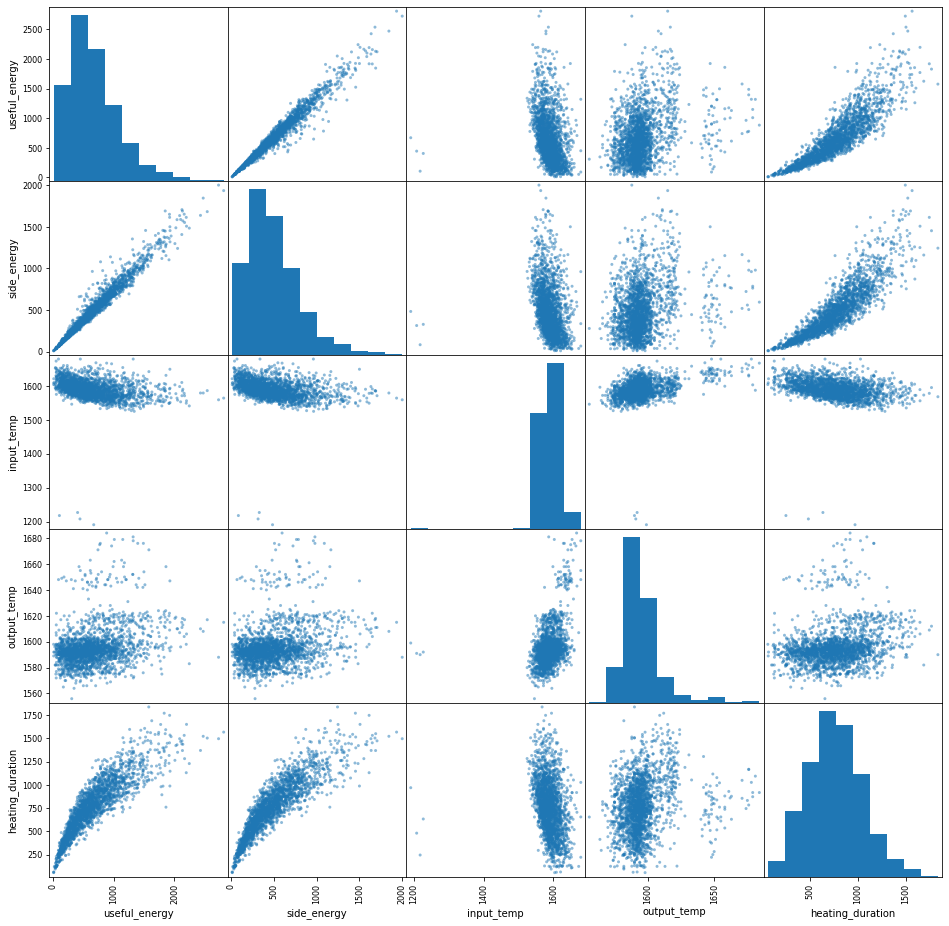

In [39]:
pd.plotting.scatter_matrix(data_true[['useful_energy', 'side_energy', 'input_temp', 'output_temp','heating_duration']], figsize = (16, 16))
pass

Удалили отрицательные значения в реактивной мощности, убрали выбросы.

In [42]:
data_true.describe()

,useful_energy,side_energy,heating_duration,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,...,output_temp,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.0,2216.000000,2216.000000,2216.000000,2216.000000,2216.00000,...,2216.000000,2216.000000,2216.000000,2216.000000,2216.0,2216.0,2216.000000,2216.0,2216.000000,2216.000000
mean,660.499061,493.823870,760.741426,2.304152,0.0,42.052347,36.734206,1.858755,17.188177,0.12500,...,1595.445397,97.944458,13.993814,0.104379,0.0,0.0,0.219394,0.0,0.061985,0.082015
std,411.933321,305.194011,288.907534,9.292221,0.0,69.504216,58.117203,20.755491,45.644235,3.79047,...,14.774656,45.656018,27.626948,4.907438,0.0,0.0,2.584523,0.0,1.683999,1.462008
min,10.614857,10.127814,57.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,...,1556.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
25%,353.261059,263.910426,559.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,...,1588.000000,69.123596,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
50%,587.976128,440.436750,750.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,...,1593.000000,100.105199,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
75%,880.820993,660.896595,948.000000,0.000000,0.0,70.000000,77.000000,0.000000,0.000000,0.00000,...,1599.000000,126.191517,16.263779,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
max,2809.885512,2003.310759,1836.000000,73.000000,0.0,405.000000,281.000000,603.000000,321.000000,155.00000,...,1684.000000,241.300813,220.348953,231.014801,0.0,0.0,50.072884,0.0,46.187439,35.053200


#### Проверка на корреляции

In [43]:
data_true.corr()

,useful_energy,side_energy,heating_duration,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,...,output_temp,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
useful_energy,1.000000,0.980583,0.879145,0.006678,NaN,0.087028,-0.011567,-0.023898,0.047632,-0.007339,...,0.299186,-0.024046,-0.030747,0.002497,NaN,NaN,-0.014228,NaN,-0.010640,-0.010261
side_energy,0.980583,1.000000,0.881279,0.017679,NaN,0.060853,-0.011031,-0.021649,0.045586,-0.004992,...,0.272009,-0.030575,-0.033675,0.002753,NaN,NaN,-0.019211,NaN,-0.015620,-0.013189
heating_duration,0.879145,0.881279,1.000000,0.034976,NaN,0.107359,0.007655,0.003702,0.091692,0.001233,...,0.221548,0.073049,0.014948,0.001986,NaN,NaN,-0.011315,NaN,-0.004369,-0.011687
Bulk 1,0.006678,0.017679,0.034976,1.000000,NaN,0.004017,0.022887,-0.022217,0.020842,-0.008181,...,-0.073392,0.080645,-0.037954,-0.005276,NaN,NaN,0.027295,NaN,-0.009131,-0.013917
Bulk 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bulk 3,0.087028,0.060853,0.107359,0.004017,NaN,1.000000,-0.271039,0.005584,0.003131,-0.019961,...,-0.063990,0.088614,0.083407,-0.012856,NaN,NaN,0.020496,NaN,0.008892,0.003170
Bulk 4,-0.011567,-0.011031,0.007655,0.022887,NaN,-0.271039,1.000000,0.014880,-0.232780,-0.020853,...,0.053553,0.343492,-0.248999,-0.013440,NaN,NaN,-0.053679,NaN,-0.023276,-0.034860
Bulk 5,-0.023898,-0.021649,0.003702,-0.022217,NaN,0.005584,0.014880,1.000000,-0.018418,-0.002955,...,-0.007810,0.047675,-0.007340,-0.001906,NaN,NaN,-0.007606,NaN,-0.003298,-0.005026
Bulk 6,0.047632,0.045586,0.091692,0.020842,NaN,0.003131,-0.232780,-0.018418,1.000000,-0.000094,...,-0.198030,-0.232808,0.165910,-0.008013,NaN,NaN,-0.015797,NaN,-0.013867,-0.021134
Bulk 7,-0.007339,-0.004992,0.001233,-0.008181,NaN,-0.019961,-0.020853,-0.002955,-0.000094,1.000000,...,-0.061923,-0.044844,0.001759,-0.000702,NaN,NaN,-0.002801,NaN,-0.001214,-0.001851


In [44]:
data_true = data_true.drop('side_energy', axis = 1)
for column_one in data_true.columns:
    for column_two in data_true.columns:
        if data_true[column_one].corr(data_true[column_two]) > 0.9 and column_one != column_two:
            data_true = data_true.drop(column_one, axis = 1)
            break

In [45]:
data_true.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2216 entries, 0 to 2462
Data columns (total 28 columns):
useful_energy       2216 non-null float64
heating_duration    2216 non-null float64
Bulk 1              2216 non-null float64
Bulk 2              2216 non-null float64
Bulk 3              2216 non-null float64
Bulk 4              2216 non-null float64
Bulk 5              2216 non-null float64
Bulk 6              2216 non-null float64
Bulk 7              2216 non-null float64
Bulk 8              2216 non-null float64
Bulk 10             2216 non-null float64
Bulk 11             2216 non-null float64
Bulk 12             2216 non-null float64
Bulk 13             2216 non-null float64
Bulk 14             2216 non-null float64
Bulk 15             2216 non-null float64
gas_1               2216 non-null float64
input_temp          2216 non-null float64
output_temp         2216 non-null float64
Wire 1              2216 non-null float64
Wire 2              2216 non-null float64
Wire 3     

In [46]:
data_true

,useful_energy,heating_duration,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,...,output_temp,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1207.804249,1098.0,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,...,1613.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,733.816470,811.0,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,...,1602.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,443.583327,655.0,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,...,1599.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,670.663327,741.0,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,...,1625.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,997.496095,869.0,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,...,1602.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2458,626.167357,723.0,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,...,1591.0,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2459,727.868032,940.0,0.0,0.0,0.0,63.0,0.0,0.0,0.0,0.0,...,1591.0,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2460,427.535518,569.0,0.0,0.0,0.0,85.0,0.0,0.0,0.0,0.0,...,1589.0,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2461,629.928649,750.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,...,1594.0,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


***Вывод***

Реактивная мощность и проактивная мощность сильно коррелировали, поэтому следует удалить один из признаков, во избежание искусственного увеличения значимости признака.

### Подготовка данных к обучению 

#### Разбиение на тренировочную и тестовую выборки

In [47]:
target = data_true['output_temp']
features = data_true.drop('output_temp', axis = 1)
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2,  random_state=12345) 
print("Размеры обучающей выборки:", len(features_train), len(target_train))
print("Размеры тестовой выборки:", len(features_test), len(target_test))
features_train = features_train.reset_index(drop = True)
target_train = target_train.reset_index(drop = True)
features_test = features_test.reset_index(drop = True)
target_test = target_test.reset_index(drop = True)

Размеры обучающей выборки: 1772 1772
Размеры тестовой выборки: 444 444


#### Масштабирование признаков

In [48]:
scaler = RobustScaler()
scaler.fit(features_train)

features_train[features_train.columns] = scaler.transform(features_train[features_train.columns])
features_test[features_test.columns] = scaler.transform(features_test[features_test.columns])

In [49]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1772 entries, 0 to 1771
Data columns (total 27 columns):
useful_energy       1772 non-null float64
heating_duration    1772 non-null float64
Bulk 1              1772 non-null float64
Bulk 2              1772 non-null float64
Bulk 3              1772 non-null float64
Bulk 4              1772 non-null float64
Bulk 5              1772 non-null float64
Bulk 6              1772 non-null float64
Bulk 7              1772 non-null float64
Bulk 8              1772 non-null float64
Bulk 10             1772 non-null float64
Bulk 11             1772 non-null float64
Bulk 12             1772 non-null float64
Bulk 13             1772 non-null float64
Bulk 14             1772 non-null float64
Bulk 15             1772 non-null float64
gas_1               1772 non-null float64
input_temp          1772 non-null float64
Wire 1              1772 non-null float64
Wire 2              1772 non-null float64
Wire 3              1772 non-null float64
Wire 4     

Разделили выборку и провели масштабирование признаков.

In [50]:
data_true.head()

,useful_energy,heating_duration,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,...,output_temp,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1207.804249,1098.0,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,...,1613.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,733.816470,811.0,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,...,1602.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,443.583327,655.0,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,...,1599.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,670.663327,741.0,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,...,1625.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,997.496095,869.0,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,...,1602.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Поиск лучшей модели

#### Модель линейной регрессии

In [51]:
best_model = LinearRegression()
predicted = cross_val_predict(best_model, features_train, target_train, cv = 5)
best_result = mean_absolute_error(predicted, target_train)
print(best_result)

7.668560789658738


#### Модель дерева решений

In [52]:
best_tree_model = None
best_tree_result = 200
for depth in range(1,11):
        model = DecisionTreeRegressor(max_depth = depth, random_state = 12345)
        predicted = cross_val_predict(model, features_train, target_train, cv = 5)
        result = mean_absolute_error(predicted, target_train)
        if result < best_tree_result:
            best_tree_model = model
            best_tree_result = result
print(best_tree_result)
if best_tree_result < best_result:
    best_model = best_tree_model 
    best_result = best_tree_result

7.01890361041334


#### Модель случайного леса

In [53]:
best_forest_model = None
best_forest_result = 200
for est in range(1, 30):
        model = RandomForestRegressor(random_state=12345, n_estimators=est) 
        predicted = cross_val_predict(model, features_train, target_train, cv = 5)
        result = mean_absolute_error(predicted, target_train)
        print(result)
        if result < best_forest_result:
            best_forest_model = model
            best_forest_result = result
print(best_forest_result)            
if best_forest_result < best_result:
    best_model = best_forest_model 
    best_result = best_forest_result

8.47686230248307
7.494356659142213
7.106847253574114
6.878103837471783
6.670654627539502
6.607975921745672
6.587391164140599
6.52073927765237
6.466265362427893
6.406884875846501
6.384619331007594
6.34683032355154
6.335344677895467
6.314535633666559
6.299623777276148
6.2883394469525955
6.298532731376975
6.275112866817156
6.263009385766899
6.249520316027088
6.2583843921315685
6.270598194130924
6.256232211208167
6.2249341610233255
6.218284424379232
6.213557041152977
6.208866315525459
6.201870364398584
6.187728652603723
6.187728652603723


#### Градиентный бустинг

***Разбиение на выборки и масштабирование***

In [54]:
target = data_true['output_temp']
features = data_true.drop('output_temp', axis = 1)
features_train, features_valid_test, target_train, target_valid_test = train_test_split(
    features, target, test_size=0.4,  random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid_test, target_valid_test, test_size=0.5,  random_state=12345)
print("Размеры обучающей выборки:", len(features_train), len(target_train))
print("Размеры валидационной выборки:", len(features_valid), len(target_valid))
print("Размеры тестовой выборки:", len(features_test), len(target_test))
features_train = features_train.reset_index(drop = True)
target_train = target_train.reset_index(drop = True)
features_test = features_test.reset_index(drop = True)
target_test = target_test.reset_index(drop = True)

scaler = RobustScaler()
scaler.fit(features_train)

features_train[features_train.columns] = scaler.transform(features_train[features_train.columns])
features_valid[features_valid.columns] = scaler.transform(features_valid[features_valid.columns])
features_test[features_test.columns] = scaler.transform(features_test[features_test.columns])

Размеры обучающей выборки: 1329 1329
Размеры валидационной выборки: 443 443
Размеры тестовой выборки: 444 444


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3498: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3469: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

#####  Бустинг без параметров 

In [55]:
%%time
results = pd.DataFrame(columns = ["mae", "time"])
columns = list(data_true.columns)
columns[17] = "Gas 1"

model = LGBMRegressor()

start_time = time.time()
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
result = mean_absolute_error(predicted_valid, target_valid)
end_time = time.time() - start_time
new_row = pd.Series(data = {"mae": result, "time": end_time}, name = "NoParamsBoost")
results = results.append(new_row, ignore_index = False)

print(result)

5.8188539854859105
CPU times: user 1.51 s, sys: 21.4 ms, total: 1.53 s
Wall time: 1.45 s


***Функция для обучения бустинга с определённым количеством параметров***

In [56]:
def boost(params, features_train, features_valid, target_train, target_valid, results, name):
    train_data = lgbm.Dataset(features_train, target_train)
    valid_data = lgbm.Dataset(features_valid, target_valid)
    
    start_time = time.time()
    model = lgbm.train(params, train_data, valid_sets = valid_data)

    predicted_valid = model.predict(features_valid)
    
    result = mean_absolute_error(predicted_valid, target_valid)
    if results['mae'].min() > result: 
        end_time = time.time() - start_time
        new_row = pd.Series(data = {"mae": result, "time": end_time}, name = name)
        results = results.append(new_row, ignore_index = False)
        print(result)
        return model, results
    return None, results
    

In [57]:
params = {
    "num_iterations" : 100,
    "num_leaves" : 21,
    "metric" : "mae",
    "learning_rate" : .1,
    "max_depth": 2,
    "lambda_l2": 0,
    "min_data_in_leaf": 20,
    "seed": 12345
}

In [58]:
%%time
for depth in range(2,6):
    for lambd in np.arange(0, 0.6, 0.1):
        params["lambda_l2"] = lambd
        params["max_depth"] = depth
        model, results = boost(params, features_train, features_valid, target_train, target_valid, results, "NumIter" + str(params["num_iterations"]) + "num_leaves" + str(params["num_leaves"]) + "md" + str(params["max_depth"]) + "l" +str(round(lambd, 2)))

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l1: 8.71262
[2]	valid_0's l1: 8.46074
[3]	valid_0's l1: 8.27935
[4]	valid_0's l1: 8.10776
[5]	valid_0's l1: 7.97475
[6]	valid_0's l1: 7.84551
[7]	valid_0's l1: 7.70784
[8]	valid_0's l1: 7.5929
[9]	valid_0's l1: 7.47508
[10]	valid_0's l1: 7.34492
[11]	valid_0's l1: 7.24061
[12]	valid_0's l1: 7.1623
[13]	valid_0's l1: 7.07308
[14]	valid_0's l1: 6.96926
[15]	valid_0's l1: 6.89277
[16]	valid_0's l1: 6.8276
[17]	valid_0's l1: 6.78626
[18]	valid_0's l1: 6.72732
[19]	valid_0's l1: 6.66534
[20]	valid_0's l1: 6.62564
[21]	valid_0's l1: 6.59103
[22]	valid_0's l1: 6.54534
[23]	valid_0's l1: 6.50913
[24]	valid_0's l1: 6.48103
[25]	valid_0's l1: 6.43579
[26]	valid_0's l1: 6.42857
[27]	valid_0's l1: 6.3868
[28]	valid_0's l1: 6.36278
[29]	valid_0's l1: 6.34611
[30]	valid_0's l1: 6.31712
[31]	valid_0's l1: 6.29484
[32]	valid_0's l1: 6.26161
[33]	valid_0's l1: 6.25308
[34]	valid_0's l1: 6.22905
[35]	valid_0's l1: 6.19787
[36]	valid_0's l1: 6.16396
[37]	valid_0's l1: 6.15738
[38]	valid_0's

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l1: 8.71298
[2]	valid_0's l1: 8.46139
[3]	valid_0's l1: 8.2801
[4]	valid_0's l1: 8.10867
[5]	valid_0's l1: 7.97579
[6]	valid_0's l1: 7.84666
[7]	valid_0's l1: 7.70904
[8]	valid_0's l1: 7.59414
[9]	valid_0's l1: 7.47637
[10]	valid_0's l1: 7.34622
[11]	valid_0's l1: 7.24193
[12]	valid_0's l1: 7.16362
[13]	valid_0's l1: 7.07444
[14]	valid_0's l1: 6.97062
[15]	valid_0's l1: 6.89416
[16]	valid_0's l1: 6.82904
[17]	valid_0's l1: 6.78771
[18]	valid_0's l1: 6.72873
[19]	valid_0's l1: 6.66679
[20]	valid_0's l1: 6.62714
[21]	valid_0's l1: 6.5964
[22]	valid_0's l1: 6.54886
[23]	valid_0's l1: 6.51373
[24]	valid_0's l1: 6.49507
[25]	valid_0's l1: 6.44672
[26]	valid_0's l1: 6.41527
[27]	valid_0's l1: 6.40052
[28]	valid_0's l1: 6.38035
[29]	valid_0's l1: 6.35425
[30]	valid_0's l1: 6.32629
[31]	valid_0's l1: 6.29217
[32]	valid_0's l1: 6.26644
[33]	valid_0's l1: 6.22951
[34]	valid_0's l1: 6.2226
[35]	valid_0's l1: 6.21922
[36]	valid_0's l1: 6.20771
[37]	valid_0's l1: 6.18803
[38]	valid_0'

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[16]	valid_0's l1: 6.83037
[17]	valid_0's l1: 6.78905
[18]	valid_0's l1: 6.73003
[19]	valid_0's l1: 6.66813
[20]	valid_0's l1: 6.62853
[21]	valid_0's l1: 6.59773
[22]	valid_0's l1: 6.55022
[23]	valid_0's l1: 6.51483
[24]	valid_0's l1: 6.49616
[25]	valid_0's l1: 6.4478
[26]	valid_0's l1: 6.41588
[27]	valid_0's l1: 6.40113
[28]	valid_0's l1: 6.38096
[29]	valid_0's l1: 6.35489
[30]	valid_0's l1: 6.32694
[31]	valid_0's l1: 6.29278
[32]	valid_0's l1: 6.26706
[33]	valid_0's l1: 6.23021
[34]	valid_0's l1: 6.2233
[35]	valid_0's l1: 6.22399
[36]	valid_0's l1: 6.19357
[37]	valid_0's l1: 6.18146
[38]	valid_0's l1: 6.18628
[39]	valid_0's l1: 6.17309
[40]	valid_0's l1: 6.16335
[41]	valid_0's l1: 6.16047
[42]	valid_0's l1: 6.14828
[43]	valid_0's l1: 6.14301
[44]	valid_0's l1: 6.12128
[45]	valid_0's l1: 6.11152
[46]	valid_0's l1: 6.09471
[47]	valid_0's l1: 6.08189
[48]	valid_0's l1: 6.07166
[49]	valid_0's l1: 6.06904
[50]	valid_0's l1: 6.06447
[51]	valid_0's l1: 6.05627
[52]	valid_0's l1: 6.05918
[5

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l1: 8.71371
[2]	valid_0's l1: 8.46268
[3]	valid_0's l1: 8.27391
[4]	valid_0's l1: 8.10983
[5]	valid_0's l1: 7.98353
[6]	valid_0's l1: 7.84884
[7]	valid_0's l1: 7.71132
[8]	valid_0's l1: 7.59651
[9]	valid_0's l1: 7.47882
[10]	valid_0's l1: 7.3487
[11]	valid_0's l1: 7.24444
[12]	valid_0's l1: 7.16614
[13]	valid_0's l1: 7.07704
[14]	valid_0's l1: 7.02815
[15]	valid_0's l1: 6.94742
[16]	valid_0's l1: 6.89111
[17]	valid_0's l1: 6.83303
[18]	valid_0's l1: 6.79358
[19]	valid_0's l1: 6.73531
[20]	valid_0's l1: 6.67166
[21]	valid_0's l1: 6.61729
[22]	valid_0's l1: 6.578
[23]	valid_0's l1: 6.55052
[24]	valid_0's l1: 6.51858
[25]	valid_0's l1: 6.4666
[26]	valid_0's l1: 6.43608
[27]	valid_0's l1: 6.39223
[28]	valid_0's l1: 6.38393
[29]	valid_0's l1: 6.3472
[30]	valid_0's l1: 6.31427
[31]	valid_0's l1: 6.29915
[32]	valid_0's l1: 6.27989
[33]	valid_0's l1: 6.25522
[34]	valid_0's l1: 6.25063
[35]	valid_0's l1: 6.23103
[36]	valid_0's l1: 6.21241
[37]	valid_0's l1: 6.18996
[38]	valid_0's 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l1: 8.71408
[2]	valid_0's l1: 8.46332
[3]	valid_0's l1: 8.27464
[4]	valid_0's l1: 8.11073
[5]	valid_0's l1: 7.98457
[6]	valid_0's l1: 7.84998
[7]	valid_0's l1: 7.70731
[8]	valid_0's l1: 7.5973
[9]	valid_0's l1: 7.47962
[10]	valid_0's l1: 7.34948
[11]	valid_0's l1: 7.24525
[12]	valid_0's l1: 7.16693
[13]	valid_0's l1: 7.07789
[14]	valid_0's l1: 7.029
[15]	valid_0's l1: 6.94829
[16]	valid_0's l1: 6.8787
[17]	valid_0's l1: 6.82088
[18]	valid_0's l1: 6.75299
[19]	valid_0's l1: 6.68806
[20]	valid_0's l1: 6.64709
[21]	valid_0's l1: 6.6166
[22]	valid_0's l1: 6.56512
[23]	valid_0's l1: 6.52901
[24]	valid_0's l1: 6.47996
[25]	valid_0's l1: 6.44705
[26]	valid_0's l1: 6.42777
[27]	valid_0's l1: 6.41108
[28]	valid_0's l1: 6.38258
[29]	valid_0's l1: 6.35155
[30]	valid_0's l1: 6.31688
[31]	valid_0's l1: 6.29225
[32]	valid_0's l1: 6.27238
[33]	valid_0's l1: 6.264
[34]	valid_0's l1: 6.25883
[35]	valid_0's l1: 6.2257
[36]	valid_0's l1: 6.20693
[37]	valid_0's l1: 6.18665
[38]	valid_0's l1:

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l1: 8.71444
[2]	valid_0's l1: 8.46396
[3]	valid_0's l1: 8.27538
[4]	valid_0's l1: 8.11163
[5]	valid_0's l1: 7.98559
[6]	valid_0's l1: 7.85111
[7]	valid_0's l1: 7.70849
[8]	valid_0's l1: 7.59852
[9]	valid_0's l1: 7.4809
[10]	valid_0's l1: 7.35077
[11]	valid_0's l1: 7.24656
[12]	valid_0's l1: 7.16824
[13]	valid_0's l1: 7.07924
[14]	valid_0's l1: 7.03037
[15]	valid_0's l1: 6.94967
[16]	valid_0's l1: 6.88004
[17]	valid_0's l1: 6.82228
[18]	valid_0's l1: 6.75433
[19]	valid_0's l1: 6.68846
[20]	valid_0's l1: 6.64756
[21]	valid_0's l1: 6.6171
[22]	valid_0's l1: 6.56586
[23]	valid_0's l1: 6.52973
[24]	valid_0's l1: 6.48101
[25]	valid_0's l1: 6.44794
[26]	valid_0's l1: 6.42887
[27]	valid_0's l1: 6.40412
[28]	valid_0's l1: 6.36348
[29]	valid_0's l1: 6.3196
[30]	valid_0's l1: 6.32078
[31]	valid_0's l1: 6.29506
[32]	valid_0's l1: 6.27955
[33]	valid_0's l1: 6.24949
[34]	valid_0's l1: 6.23026
[35]	valid_0's l1: 6.19956
[36]	valid_0's l1: 6.17704
[37]	valid_0's l1: 6.15379
[38]	valid_0'

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l1: 8.69081
[2]	valid_0's l1: 8.40763
[3]	valid_0's l1: 8.17475
[4]	valid_0's l1: 7.98788
[5]	valid_0's l1: 7.82281
[6]	valid_0's l1: 7.66798
[7]	valid_0's l1: 7.49814
[8]	valid_0's l1: 7.35113
[9]	valid_0's l1: 7.21313
[10]	valid_0's l1: 7.10377
[11]	valid_0's l1: 7.02953
[12]	valid_0's l1: 6.90877
[13]	valid_0's l1: 6.81326
[14]	valid_0's l1: 6.71479
[15]	valid_0's l1: 6.6536
[16]	valid_0's l1: 6.59652
[17]	valid_0's l1: 6.53532
[18]	valid_0's l1: 6.51759
[19]	valid_0's l1: 6.47174
[20]	valid_0's l1: 6.45194
[21]	valid_0's l1: 6.41961
[22]	valid_0's l1: 6.36832
[23]	valid_0's l1: 6.33946
[24]	valid_0's l1: 6.3253
[25]	valid_0's l1: 6.30695
[26]	valid_0's l1: 6.26213
[27]	valid_0's l1: 6.25096
[28]	valid_0's l1: 6.23111
[29]	valid_0's l1: 6.22371
[30]	valid_0's l1: 6.19732
[31]	valid_0's l1: 6.18062
[32]	valid_0's l1: 6.16841
[33]	valid_0's l1: 6.15259
[34]	valid_0's l1: 6.14836
[35]	valid_0's l1: 6.15118
[36]	valid_0's l1: 6.13145
[37]	valid_0's l1: 6.12585
[38]	valid_0

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l1: 8.69156
[2]	valid_0's l1: 8.4089
[3]	valid_0's l1: 8.17645
[4]	valid_0's l1: 7.98967
[5]	valid_0's l1: 7.82486
[6]	valid_0's l1: 7.67022
[7]	valid_0's l1: 7.50049
[8]	valid_0's l1: 7.35355
[9]	valid_0's l1: 7.21555
[10]	valid_0's l1: 7.11067
[11]	valid_0's l1: 7.00899
[12]	valid_0's l1: 6.89017
[13]	valid_0's l1: 6.79202
[14]	valid_0's l1: 6.69618
[15]	valid_0's l1: 6.61477
[16]	valid_0's l1: 6.56105
[17]	valid_0's l1: 6.50486
[18]	valid_0's l1: 6.45877
[19]	valid_0's l1: 6.42174
[20]	valid_0's l1: 6.40239
[21]	valid_0's l1: 6.34655
[22]	valid_0's l1: 6.32147
[23]	valid_0's l1: 6.29532
[24]	valid_0's l1: 6.24815
[25]	valid_0's l1: 6.23382
[26]	valid_0's l1: 6.21376
[27]	valid_0's l1: 6.19758
[28]	valid_0's l1: 6.1832
[29]	valid_0's l1: 6.16778
[30]	valid_0's l1: 6.15862
[31]	valid_0's l1: 6.13488
[32]	valid_0's l1: 6.12849
[33]	valid_0's l1: 6.11482
[34]	valid_0's l1: 6.10863
[35]	valid_0's l1: 6.08165
[36]	valid_0's l1: 6.06687
[37]	valid_0's l1: 6.0592
[38]	valid_0'

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l1: 8.69229
[2]	valid_0's l1: 8.41016
[3]	valid_0's l1: 8.17815
[4]	valid_0's l1: 7.99146
[5]	valid_0's l1: 7.81864
[6]	valid_0's l1: 7.63726
[7]	valid_0's l1: 7.50572
[8]	valid_0's l1: 7.35595
[9]	valid_0's l1: 7.22047
[10]	valid_0's l1: 7.11786
[11]	valid_0's l1: 7.01735
[12]	valid_0's l1: 6.8869
[13]	valid_0's l1: 6.78854
[14]	valid_0's l1: 6.71003
[15]	valid_0's l1: 6.62789
[16]	valid_0's l1: 6.58955
[17]	valid_0's l1: 6.53662
[18]	valid_0's l1: 6.50288
[19]	valid_0's l1: 6.46615
[20]	valid_0's l1: 6.42121
[21]	valid_0's l1: 6.37085
[22]	valid_0's l1: 6.33788
[23]	valid_0's l1: 6.28622
[24]	valid_0's l1: 6.25699
[25]	valid_0's l1: 6.23343
[26]	valid_0's l1: 6.19776
[27]	valid_0's l1: 6.18484
[28]	valid_0's l1: 6.17981
[29]	valid_0's l1: 6.15034
[30]	valid_0's l1: 6.13805
[31]	valid_0's l1: 6.12426
[32]	valid_0's l1: 6.10852
[33]	valid_0's l1: 6.09732
[34]	valid_0's l1: 6.09256
[35]	valid_0's l1: 6.08084
[36]	valid_0's l1: 6.07376
[37]	valid_0's l1: 6.07602
[38]	valid_

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l1: 8.69302
[2]	valid_0's l1: 8.41141
[3]	valid_0's l1: 8.17983
[4]	valid_0's l1: 7.99322
[5]	valid_0's l1: 7.82118
[6]	valid_0's l1: 7.64007
[7]	valid_0's l1: 7.50247
[8]	valid_0's l1: 7.35711
[9]	valid_0's l1: 7.22173
[10]	valid_0's l1: 7.11918
[11]	valid_0's l1: 7.0187
[12]	valid_0's l1: 6.8883
[13]	valid_0's l1: 6.78864
[14]	valid_0's l1: 6.70758
[15]	valid_0's l1: 6.62553
[16]	valid_0's l1: 6.58456
[17]	valid_0's l1: 6.52952
[18]	valid_0's l1: 6.49556
[19]	valid_0's l1: 6.45769
[20]	valid_0's l1: 6.41177
[21]	valid_0's l1: 6.36147
[22]	valid_0's l1: 6.32848
[23]	valid_0's l1: 6.27678
[24]	valid_0's l1: 6.2476
[25]	valid_0's l1: 6.23665
[26]	valid_0's l1: 6.20173
[27]	valid_0's l1: 6.18312
[28]	valid_0's l1: 6.17095
[29]	valid_0's l1: 6.14287
[30]	valid_0's l1: 6.13327
[31]	valid_0's l1: 6.12121
[32]	valid_0's l1: 6.12227
[33]	valid_0's l1: 6.11016
[34]	valid_0's l1: 6.10426
[35]	valid_0's l1: 6.09772
[36]	valid_0's l1: 6.06581
[37]	valid_0's l1: 6.05637
[38]	valid_0'

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l1: 8.69374
[2]	valid_0's l1: 8.41264
[3]	valid_0's l1: 8.1815
[4]	valid_0's l1: 7.99346
[5]	valid_0's l1: 7.82112
[6]	valid_0's l1: 7.64039
[7]	valid_0's l1: 7.50345
[8]	valid_0's l1: 7.35815
[9]	valid_0's l1: 7.22279
[10]	valid_0's l1: 7.12039
[11]	valid_0's l1: 7.01987
[12]	valid_0's l1: 6.88962
[13]	valid_0's l1: 6.79121
[14]	valid_0's l1: 6.70984
[15]	valid_0's l1: 6.62771
[16]	valid_0's l1: 6.58907
[17]	valid_0's l1: 6.53394
[18]	valid_0's l1: 6.48652
[19]	valid_0's l1: 6.44843
[20]	valid_0's l1: 6.39606
[21]	valid_0's l1: 6.34054
[22]	valid_0's l1: 6.31602
[23]	valid_0's l1: 6.29364
[24]	valid_0's l1: 6.2806
[25]	valid_0's l1: 6.2343
[26]	valid_0's l1: 6.21804
[27]	valid_0's l1: 6.18035
[28]	valid_0's l1: 6.17015
[29]	valid_0's l1: 6.15665
[30]	valid_0's l1: 6.14288
[31]	valid_0's l1: 6.13195
[32]	valid_0's l1: 6.12432
[33]	valid_0's l1: 6.11206
[34]	valid_0's l1: 6.08397
[35]	valid_0's l1: 6.06737
[36]	valid_0's l1: 6.0649
[37]	valid_0's l1: 6.05389
[38]	valid_0's

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l1: 8.68911
[2]	valid_0's l1: 8.40886
[3]	valid_0's l1: 8.17844
[4]	valid_0's l1: 7.99286
[5]	valid_0's l1: 7.82082
[6]	valid_0's l1: 7.64053
[7]	valid_0's l1: 7.50328
[8]	valid_0's l1: 7.358
[9]	valid_0's l1: 7.22277
[10]	valid_0's l1: 7.12047
[11]	valid_0's l1: 7.02
[12]	valid_0's l1: 6.88994
[13]	valid_0's l1: 6.79154
[14]	valid_0's l1: 6.70954
[15]	valid_0's l1: 6.62653
[16]	valid_0's l1: 6.5879
[17]	valid_0's l1: 6.53137
[18]	valid_0's l1: 6.48394
[19]	valid_0's l1: 6.44598
[20]	valid_0's l1: 6.39224
[21]	valid_0's l1: 6.37316
[22]	valid_0's l1: 6.32004
[23]	valid_0's l1: 6.30289
[24]	valid_0's l1: 6.25538
[25]	valid_0's l1: 6.23065
[26]	valid_0's l1: 6.2087
[27]	valid_0's l1: 6.17872
[28]	valid_0's l1: 6.16486
[29]	valid_0's l1: 6.15199
[30]	valid_0's l1: 6.12616
[31]	valid_0's l1: 6.11066
[32]	valid_0's l1: 6.10431
[33]	valid_0's l1: 6.09697
[34]	valid_0's l1: 6.08591
[35]	valid_0's l1: 6.07914
[36]	valid_0's l1: 6.06852
[37]	valid_0's l1: 6.06134
[38]	valid_0's l1

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l1: 8.65676
[2]	valid_0's l1: 8.36218
[3]	valid_0's l1: 8.08429
[4]	valid_0's l1: 7.87572
[5]	valid_0's l1: 7.7142
[6]	valid_0's l1: 7.50957
[7]	valid_0's l1: 7.33478
[8]	valid_0's l1: 7.18252
[9]	valid_0's l1: 7.06626
[10]	valid_0's l1: 6.93218
[11]	valid_0's l1: 6.82612
[12]	valid_0's l1: 6.74627
[13]	valid_0's l1: 6.64851
[14]	valid_0's l1: 6.53244
[15]	valid_0's l1: 6.45038
[16]	valid_0's l1: 6.39562
[17]	valid_0's l1: 6.33607
[18]	valid_0's l1: 6.30392
[19]	valid_0's l1: 6.28232
[20]	valid_0's l1: 6.24646
[21]	valid_0's l1: 6.22104
[22]	valid_0's l1: 6.17631
[23]	valid_0's l1: 6.14525
[24]	valid_0's l1: 6.10317
[25]	valid_0's l1: 6.08141
[26]	valid_0's l1: 6.05795
[27]	valid_0's l1: 6.04725
[28]	valid_0's l1: 6.01657
[29]	valid_0's l1: 6.01144
[30]	valid_0's l1: 5.99232
[31]	valid_0's l1: 5.97989
[32]	valid_0's l1: 5.95947
[33]	valid_0's l1: 5.93983
[34]	valid_0's l1: 5.92454
[35]	valid_0's l1: 5.92125
[36]	valid_0's l1: 5.90876
[37]	valid_0's l1: 5.89858
[38]	valid_

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l1: 8.65762
[2]	valid_0's l1: 8.36363
[3]	valid_0's l1: 8.08619
[4]	valid_0's l1: 7.87776
[5]	valid_0's l1: 7.71656
[6]	valid_0's l1: 7.51214
[7]	valid_0's l1: 7.33749
[8]	valid_0's l1: 7.18533
[9]	valid_0's l1: 7.06909
[10]	valid_0's l1: 6.9351
[11]	valid_0's l1: 6.82896
[12]	valid_0's l1: 6.7491
[13]	valid_0's l1: 6.65126
[14]	valid_0's l1: 6.53515
[15]	valid_0's l1: 6.45289
[16]	valid_0's l1: 6.3976
[17]	valid_0's l1: 6.34283
[18]	valid_0's l1: 6.30684
[19]	valid_0's l1: 6.28696
[20]	valid_0's l1: 6.2521
[21]	valid_0's l1: 6.22656
[22]	valid_0's l1: 6.17238
[23]	valid_0's l1: 6.13841
[24]	valid_0's l1: 6.11361
[25]	valid_0's l1: 6.07817
[26]	valid_0's l1: 6.05767
[27]	valid_0's l1: 6.02858
[28]	valid_0's l1: 6.00291
[29]	valid_0's l1: 5.97719
[30]	valid_0's l1: 5.97562
[31]	valid_0's l1: 5.96581
[32]	valid_0's l1: 5.95247
[33]	valid_0's l1: 5.93695
[34]	valid_0's l1: 5.93274
[35]	valid_0's l1: 5.92779
[36]	valid_0's l1: 5.91639
[37]	valid_0's l1: 5.9063
[38]	valid_0's 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[2]	valid_0's l1: 8.36507
[3]	valid_0's l1: 8.08808
[4]	valid_0's l1: 7.8804
[5]	valid_0's l1: 7.71212
[6]	valid_0's l1: 7.51491
[7]	valid_0's l1: 7.34621
[8]	valid_0's l1: 7.18981
[9]	valid_0's l1: 7.07359
[10]	valid_0's l1: 6.94018
[11]	valid_0's l1: 6.83375
[12]	valid_0's l1: 6.7539
[13]	valid_0's l1: 6.6561
[14]	valid_0's l1: 6.54504
[15]	valid_0's l1: 6.4549
[16]	valid_0's l1: 6.37869
[17]	valid_0's l1: 6.31533
[18]	valid_0's l1: 6.27798
[19]	valid_0's l1: 6.26003
[20]	valid_0's l1: 6.2217
[21]	valid_0's l1: 6.19886
[22]	valid_0's l1: 6.17581
[23]	valid_0's l1: 6.133
[24]	valid_0's l1: 6.09986
[25]	valid_0's l1: 6.08197
[26]	valid_0's l1: 6.0654
[27]	valid_0's l1: 6.05251
[28]	valid_0's l1: 6.02016
[29]	valid_0's l1: 6.01217
[30]	valid_0's l1: 6.0039
[31]	valid_0's l1: 5.97267
[32]	valid_0's l1: 5.96713
[33]	valid_0's l1: 5.95054
[34]	valid_0's l1: 5.93917
[35]	valid_0's l1: 5.93821
[36]	valid_0's l1: 5.9176
[37]	valid_0's l1: 5.91393
[38]	valid_0's l1: 5.91141
[39]	valid_0's l1: 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[3]	valid_0's l1: 8.08632
[4]	valid_0's l1: 7.88008
[5]	valid_0's l1: 7.70191
[6]	valid_0's l1: 7.50958
[7]	valid_0's l1: 7.32642
[8]	valid_0's l1: 7.19871
[9]	valid_0's l1: 7.06557
[10]	valid_0's l1: 6.90773
[11]	valid_0's l1: 6.80011
[12]	valid_0's l1: 6.6848
[13]	valid_0's l1: 6.58048
[14]	valid_0's l1: 6.49594
[15]	valid_0's l1: 6.42234
[16]	valid_0's l1: 6.35209
[17]	valid_0's l1: 6.27877
[18]	valid_0's l1: 6.22009
[19]	valid_0's l1: 6.1827
[20]	valid_0's l1: 6.13868
[21]	valid_0's l1: 6.08366
[22]	valid_0's l1: 6.06234
[23]	valid_0's l1: 6.01806
[24]	valid_0's l1: 5.98976
[25]	valid_0's l1: 5.98413
[26]	valid_0's l1: 5.96467
[27]	valid_0's l1: 5.95147
[28]	valid_0's l1: 5.92225
[29]	valid_0's l1: 5.91135
[30]	valid_0's l1: 5.90721
[31]	valid_0's l1: 5.89888
[32]	valid_0's l1: 5.88479
[33]	valid_0's l1: 5.86172
[34]	valid_0's l1: 5.85395
[35]	valid_0's l1: 5.83975
[36]	valid_0's l1: 5.83214
[37]	valid_0's l1: 5.83016
[38]	valid_0's l1: 5.82896
[39]	valid_0's l1: 5.82375
[40]	valid

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[2]	valid_0's l1: 8.36532
[3]	valid_0's l1: 8.08818
[4]	valid_0's l1: 7.88055
[5]	valid_0's l1: 7.70215
[6]	valid_0's l1: 7.51019
[7]	valid_0's l1: 7.32773
[8]	valid_0's l1: 7.20008
[9]	valid_0's l1: 7.06801
[10]	valid_0's l1: 6.91029
[11]	valid_0's l1: 6.79797
[12]	valid_0's l1: 6.70728
[13]	valid_0's l1: 6.60929
[14]	valid_0's l1: 6.51561
[15]	valid_0's l1: 6.43604
[16]	valid_0's l1: 6.38822
[17]	valid_0's l1: 6.31907
[18]	valid_0's l1: 6.27897
[19]	valid_0's l1: 6.23637
[20]	valid_0's l1: 6.20251
[21]	valid_0's l1: 6.17479
[22]	valid_0's l1: 6.13977
[23]	valid_0's l1: 6.10767
[24]	valid_0's l1: 6.10439
[25]	valid_0's l1: 6.07732
[26]	valid_0's l1: 6.06192
[27]	valid_0's l1: 6.04954
[28]	valid_0's l1: 6.02766
[29]	valid_0's l1: 5.99606
[30]	valid_0's l1: 5.98296
[31]	valid_0's l1: 5.97976
[32]	valid_0's l1: 5.96284
[33]	valid_0's l1: 5.95179
[34]	valid_0's l1: 5.93563
[35]	valid_0's l1: 5.92098
[36]	valid_0's l1: 5.91906
[37]	valid_0's l1: 5.91184
[38]	valid_0's l1: 5.91158
[39]	vali

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l1: 8.65087
[2]	valid_0's l1: 8.36174
[3]	valid_0's l1: 8.08532
[4]	valid_0's l1: 7.88019
[5]	valid_0's l1: 7.70215
[6]	valid_0's l1: 7.51063
[7]	valid_0's l1: 7.32783
[8]	valid_0's l1: 7.18362
[9]	valid_0's l1: 7.03934
[10]	valid_0's l1: 6.90969
[11]	valid_0's l1: 6.81526
[12]	valid_0's l1: 6.7081
[13]	valid_0's l1: 6.59105
[14]	valid_0's l1: 6.50631
[15]	valid_0's l1: 6.43572
[16]	valid_0's l1: 6.3741
[17]	valid_0's l1: 6.29843
[18]	valid_0's l1: 6.24598
[19]	valid_0's l1: 6.20774
[20]	valid_0's l1: 6.18037
[21]	valid_0's l1: 6.15251
[22]	valid_0's l1: 6.11507
[23]	valid_0's l1: 6.08672
[24]	valid_0's l1: 6.03865
[25]	valid_0's l1: 6.01886
[26]	valid_0's l1: 5.99752
[27]	valid_0's l1: 5.96053
[28]	valid_0's l1: 5.93951
[29]	valid_0's l1: 5.93045
[30]	valid_0's l1: 5.93025
[31]	valid_0's l1: 5.90222
[32]	valid_0's l1: 5.88757
[33]	valid_0's l1: 5.87606
[34]	valid_0's l1: 5.86663
[35]	valid_0's l1: 5.86773
[36]	valid_0's l1: 5.85721
[37]	valid_0's l1: 5.84756
[38]	valid_0

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l1: 8.59402
[2]	valid_0's l1: 8.2601
[3]	valid_0's l1: 7.98842
[4]	valid_0's l1: 7.71432
[5]	valid_0's l1: 7.50591
[6]	valid_0's l1: 7.34407
[7]	valid_0's l1: 7.15076
[8]	valid_0's l1: 7.02818
[9]	valid_0's l1: 6.85457
[10]	valid_0's l1: 6.71373
[11]	valid_0's l1: 6.60318
[12]	valid_0's l1: 6.50706
[13]	valid_0's l1: 6.40854
[14]	valid_0's l1: 6.31946
[15]	valid_0's l1: 6.24135
[16]	valid_0's l1: 6.18321
[17]	valid_0's l1: 6.11343
[18]	valid_0's l1: 6.07231
[19]	valid_0's l1: 6.02801
[20]	valid_0's l1: 5.99912
[21]	valid_0's l1: 5.96174
[22]	valid_0's l1: 5.92941
[23]	valid_0's l1: 5.90711
[24]	valid_0's l1: 5.89729
[25]	valid_0's l1: 5.87981
[26]	valid_0's l1: 5.88569
[27]	valid_0's l1: 5.88214
[28]	valid_0's l1: 5.86512
[29]	valid_0's l1: 5.85482
[30]	valid_0's l1: 5.85213
[31]	valid_0's l1: 5.85294
[32]	valid_0's l1: 5.848
[33]	valid_0's l1: 5.82877
[34]	valid_0's l1: 5.83142
[35]	valid_0's l1: 5.82941
[36]	valid_0's l1: 5.8288
[37]	valid_0's l1: 5.81028
[38]	valid_0's

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l1: 8.59511
[2]	valid_0's l1: 8.26202
[3]	valid_0's l1: 7.99081
[4]	valid_0's l1: 7.71419
[5]	valid_0's l1: 7.50604
[6]	valid_0's l1: 7.34447
[7]	valid_0's l1: 7.15122
[8]	valid_0's l1: 7.02891
[9]	valid_0's l1: 6.87054
[10]	valid_0's l1: 6.74056
[11]	valid_0's l1: 6.6293
[12]	valid_0's l1: 6.53166
[13]	valid_0's l1: 6.43109
[14]	valid_0's l1: 6.34275
[15]	valid_0's l1: 6.26858
[16]	valid_0's l1: 6.18516
[17]	valid_0's l1: 6.12371
[18]	valid_0's l1: 6.07247
[19]	valid_0's l1: 6.02924
[20]	valid_0's l1: 5.98946
[21]	valid_0's l1: 5.94887
[22]	valid_0's l1: 5.90491
[23]	valid_0's l1: 5.88765
[24]	valid_0's l1: 5.8706
[25]	valid_0's l1: 5.85026
[26]	valid_0's l1: 5.82659
[27]	valid_0's l1: 5.83093
[28]	valid_0's l1: 5.81105
[29]	valid_0's l1: 5.80591
[30]	valid_0's l1: 5.79845
[31]	valid_0's l1: 5.77551
[32]	valid_0's l1: 5.7671
[33]	valid_0's l1: 5.76507
[34]	valid_0's l1: 5.75642
[35]	valid_0's l1: 5.77079
[36]	valid_0's l1: 5.77333
[37]	valid_0's l1: 5.77151
[38]	valid_0'

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[4]	valid_0's l1: 7.71682
[5]	valid_0's l1: 7.50144
[6]	valid_0's l1: 7.34711
[7]	valid_0's l1: 7.15974
[8]	valid_0's l1: 7.03321
[9]	valid_0's l1: 6.8749
[10]	valid_0's l1: 6.7455
[11]	valid_0's l1: 6.63389
[12]	valid_0's l1: 6.53603
[13]	valid_0's l1: 6.4353
[14]	valid_0's l1: 6.34687
[15]	valid_0's l1: 6.2656
[16]	valid_0's l1: 6.2107
[17]	valid_0's l1: 6.15421
[18]	valid_0's l1: 6.09724
[19]	valid_0's l1: 6.04546
[20]	valid_0's l1: 5.99897
[21]	valid_0's l1: 5.95959
[22]	valid_0's l1: 5.92909
[23]	valid_0's l1: 5.90471
[24]	valid_0's l1: 5.88575
[25]	valid_0's l1: 5.86757
[26]	valid_0's l1: 5.86758
[27]	valid_0's l1: 5.84375
[28]	valid_0's l1: 5.83537
[29]	valid_0's l1: 5.81696
[30]	valid_0's l1: 5.83101
[31]	valid_0's l1: 5.81542
[32]	valid_0's l1: 5.80494
[33]	valid_0's l1: 5.783
[34]	valid_0's l1: 5.77442
[35]	valid_0's l1: 5.77323
[36]	valid_0's l1: 5.76944
[37]	valid_0's l1: 5.76805
[38]	valid_0's l1: 5.76426
[39]	valid_0's l1: 5.76662
[40]	valid_0's l1: 5.77287
[41]	valid_0's

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l1: 8.59749
[2]	valid_0's l1: 8.2656
[3]	valid_0's l1: 7.96803
[4]	valid_0's l1: 7.71685
[5]	valid_0's l1: 7.47687
[6]	valid_0's l1: 7.32875
[7]	valid_0's l1: 7.12502
[8]	valid_0's l1: 6.99241
[9]	valid_0's l1: 6.85205
[10]	valid_0's l1: 6.67725
[11]	valid_0's l1: 6.57945
[12]	valid_0's l1: 6.49219
[13]	valid_0's l1: 6.38831
[14]	valid_0's l1: 6.29542
[15]	valid_0's l1: 6.19924
[16]	valid_0's l1: 6.1346
[17]	valid_0's l1: 6.0687
[18]	valid_0's l1: 6.02769
[19]	valid_0's l1: 5.99163
[20]	valid_0's l1: 5.95978
[21]	valid_0's l1: 5.92574
[22]	valid_0's l1: 5.89459
[23]	valid_0's l1: 5.87253
[24]	valid_0's l1: 5.85315
[25]	valid_0's l1: 5.84895
[26]	valid_0's l1: 5.84218
[27]	valid_0's l1: 5.83017
[28]	valid_0's l1: 5.81903
[29]	valid_0's l1: 5.81581
[30]	valid_0's l1: 5.80165
[31]	valid_0's l1: 5.80381
[32]	valid_0's l1: 5.7988
[33]	valid_0's l1: 5.78494
[34]	valid_0's l1: 5.78583
[35]	valid_0's l1: 5.77652
[36]	valid_0's l1: 5.76815
[37]	valid_0's l1: 5.77207
[38]	valid_0's

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l1: 8.59855
[2]	valid_0's l1: 8.26751
[3]	valid_0's l1: 7.97037
[4]	valid_0's l1: 7.71789
[5]	valid_0's l1: 7.47779
[6]	valid_0's l1: 7.33015
[7]	valid_0's l1: 7.12701
[8]	valid_0's l1: 6.99455
[9]	valid_0's l1: 6.85526
[10]	valid_0's l1: 6.6806
[11]	valid_0's l1: 6.58254
[12]	valid_0's l1: 6.49535
[13]	valid_0's l1: 6.39237
[14]	valid_0's l1: 6.29778
[15]	valid_0's l1: 6.22374
[16]	valid_0's l1: 6.16403
[17]	valid_0's l1: 6.08997
[18]	valid_0's l1: 6.04731
[19]	valid_0's l1: 6.00241
[20]	valid_0's l1: 5.9567
[21]	valid_0's l1: 5.93421
[22]	valid_0's l1: 5.90626
[23]	valid_0's l1: 5.88819
[24]	valid_0's l1: 5.86604
[25]	valid_0's l1: 5.85211
[26]	valid_0's l1: 5.85257
[27]	valid_0's l1: 5.84053
[28]	valid_0's l1: 5.82776
[29]	valid_0's l1: 5.81015
[30]	valid_0's l1: 5.80296
[31]	valid_0's l1: 5.78566
[32]	valid_0's l1: 5.78611
[33]	valid_0's l1: 5.77515
[34]	valid_0's l1: 5.76929
[35]	valid_0's l1: 5.77024
[36]	valid_0's l1: 5.76195
[37]	valid_0's l1: 5.74998
[38]	valid_0

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l1: 8.59426
[2]	valid_0's l1: 8.25675
[3]	valid_0's l1: 7.95954
[4]	valid_0's l1: 7.70976
[5]	valid_0's l1: 7.47151
[6]	valid_0's l1: 7.31695
[7]	valid_0's l1: 7.14349
[8]	valid_0's l1: 6.97868
[9]	valid_0's l1: 6.8666
[10]	valid_0's l1: 6.73839
[11]	valid_0's l1: 6.61981
[12]	valid_0's l1: 6.51431
[13]	valid_0's l1: 6.41092
[14]	valid_0's l1: 6.34886
[15]	valid_0's l1: 6.27153
[16]	valid_0's l1: 6.20947
[17]	valid_0's l1: 6.13883
[18]	valid_0's l1: 6.08968
[19]	valid_0's l1: 6.05262
[20]	valid_0's l1: 5.99697
[21]	valid_0's l1: 5.95707
[22]	valid_0's l1: 5.94068
[23]	valid_0's l1: 5.91933
[24]	valid_0's l1: 5.90214
[25]	valid_0's l1: 5.88602
[26]	valid_0's l1: 5.85652
[27]	valid_0's l1: 5.85071
[28]	valid_0's l1: 5.84758
[29]	valid_0's l1: 5.8367
[30]	valid_0's l1: 5.83942
[31]	valid_0's l1: 5.82655
[32]	valid_0's l1: 5.8199
[33]	valid_0's l1: 5.79906
[34]	valid_0's l1: 5.80705
[35]	valid_0's l1: 5.80327
[36]	valid_0's l1: 5.78855
[37]	valid_0's l1: 5.78397
[38]	valid_0'

In [59]:
print(results)

                                    mae      time
NoParamsBoost                  5.818854  1.447031
NumIter100num_leaves21md4l0.0  5.806362  0.909776
NumIter100num_leaves21md4l0.3  5.752557  1.198255
NumIter100num_leaves21md4l0.5  5.704289  0.990699


***Вывод***

Модель градиентного бустинга оказалась наилучшей, а также мы нашли параметры ещё улучшившие эту модель.

### Тестирование модели

#### Дообучение и проверка самой модели

In [60]:
params = {
    "num_iterations" : 100,
    "metric" : "mae",
    "learning_rate" : .1,
    "seed" : 12345,
    "max_depth": 4,
    "lambda_l2": 0.5,
    "seed": 12345
}

In [61]:
features = np.row_stack([features_train, features_valid])
target = np.concatenate([target_train, target_valid])


scaler = RobustScaler()
scaler.fit(features)

features = scaler.transform(features)
features_test = scaler.transform(features_test)

train_data = lgbm.Dataset(features, target)
valid_data = lgbm.Dataset(features_test, target_test) 
model = lgbm.train(params, train_data, valid_sets = valid_data)
predicted_test = model.predict(features_test)  
result = mean_absolute_error(predicted_test, target_test)
print(result)

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l1: 9.40642
[2]	valid_0's l1: 9.0304
[3]	valid_0's l1: 8.70561
[4]	valid_0's l1: 8.45595
[5]	valid_0's l1: 8.26209
[6]	valid_0's l1: 8.05799
[7]	valid_0's l1: 7.8756
[8]	valid_0's l1: 7.68614
[9]	valid_0's l1: 7.53764
[10]	valid_0's l1: 7.40946
[11]	valid_0's l1: 7.2839
[12]	valid_0's l1: 7.1469
[13]	valid_0's l1: 7.04568
[14]	valid_0's l1: 6.92984
[15]	valid_0's l1: 6.82825
[16]	valid_0's l1: 6.73834
[17]	valid_0's l1: 6.66045
[18]	valid_0's l1: 6.58621
[19]	valid_0's l1: 6.51853
[20]	valid_0's l1: 6.46658
[21]	valid_0's l1: 6.4255
[22]	valid_0's l1: 6.35912
[23]	valid_0's l1: 6.3332
[24]	valid_0's l1: 6.29396
[25]	valid_0's l1: 6.2638
[26]	valid_0's l1: 6.24557
[27]	valid_0's l1: 6.23755
[28]	valid_0's l1: 6.21848
[29]	valid_0's l1: 6.20218
[30]	valid_0's l1: 6.18546
[31]	valid_0's l1: 6.16447
[32]	valid_0's l1: 6.15889
[33]	valid_0's l1: 6.15209
[34]	valid_0's l1: 6.13745
[35]	valid_0's l1: 6.11514
[36]	valid_0's l1: 6.11311
[37]	valid_0's l1: 6.10075
[38]	valid_0's l1

#### Проверка модели на адекватность

In [62]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features, target)
dummy_predict = dummy_regr.predict(features_test)
dummy_result = mean_absolute_error(target_test, dummy_predict)
print(dummy_result)

9.81485774713763


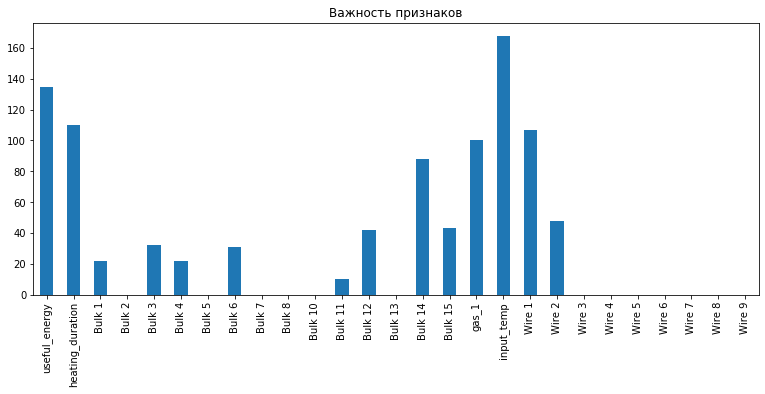

In [63]:
plt.figure(figsize = (13, 5))
importances = model.feature_importance()
model_importances = pd.Series(importances, index = features_train.columns) 

model_importances.plot.bar()
plt.title("Важность признаков")
plt.show()

***Вывод***

Мы построили модель, которая справляется с задачей лучше, чем простая модель, а также теперь знаем, что на конечную энергию больше всего влияют начальная температура, потраченная энергия, добавка первой проволочной примеси. Теперь видно, на какие признаки стоит делать упор для уменьшения необходимой температуры.